In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/adult-census-income")
print("Path to dataset files:", path)

# Build full path to the CSV file inside that folder
csv_path = os.path.join(path, "adult.csv")

# Load the CSV (it already has a header row on Kaggle)
df = pd.read_csv(
    csv_path,
    na_values='?',
    skipinitialspace=True
)

print(df.head())
print(df.columns)

categorical_features = [
    "workclass",
    "education",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native.country",
]

target_col = "income"

df = df[categorical_features + [target_col]]

# stripping whitespace from categorical features and target column
# making ? a separate category to include it in calculations
for col in categorical_features + [target_col]:
    df[col] = df[col].astype(str).str.strip()

df = df.fillna("?")

Using Colab cache for faster access to the 'adult-census-income' dataset.
Path to dataset files: /kaggle/input/adult-census-income
   age workclass  fnlwgt     education  education.num marital.status  \
0   90       NaN   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66       NaN  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                NaN  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                NaN      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.

In [ ]:
feature_mappings = {}

def encode_column(series):
    """
    Encode a pandas Series of strings into integers and
    return the encoded series + mapping dict.
    """
    unique_values = sorted(series.unique())  # sort for consistency
    mapping = {value: idx for idx, value in enumerate(unique_values)}
    encoded = series.map(mapping)
    return encoded, mapping

# Encode all categorical features
for col in categorical_features:
    encoded_col, mapping = encode_column(df[col])
    df[col] = encoded_col
    feature_mappings[col] = mapping

# Encode target (income) to 0/1
# Example: '<=50K' -> 0, '>50K' -> 1
target_values = sorted(df[target_col].unique())
target_mapping = {value: idx for idx, value in enumerate(target_values)}
df[target_col] = df[target_col].map(target_mapping)

print("Target mapping:", target_mapping)
print("\nFeature mappings example (first feature):")
first_feat = categorical_features[0]
print(first_feat, ":", feature_mappings[first_feat])


#  Split into 70% / 15% / 15% (stratified)

X = df[categorical_features].values
y = df[target_col].values

# First: train (70%) vs temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42,
)

# Second: split temp into validation (15%) and test (15%)
# 0.15 / 0.30 = 0.5  → so we split temp 50/50
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42,
)

print("\nShapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


# 6) Analyze class distribution
def describe_class_distribution(y, name):
    unique, counts = pd.Series(y).value_counts().sort_index().index, pd.Series(y).value_counts().sort_index().values
    total = len(y)
    print(f"\nClass distribution in {name}:")
    for cls, cnt in zip(unique, counts):
        pct = cnt / total * 100
        # Map back to original label using inverse mapping
        inv_target_mapping = {v: k for k, v in target_mapping.items()}
        print(f"  Class {cls} ({inv_target_mapping[cls]}): {cnt} samples ({pct:.2f}%)")

describe_class_distribution(y_train, "TRAIN")
describe_class_distribution(y_val, "VALIDATION")
describe_class_distribution(y_test, "TEST")


#  Analyze feature–target relationships (on full data or train only)


full_df = df.copy()
full_df[target_col] = full_df[target_col].map({v: k for k, v in target_mapping.items()})  # back to original labels

print("\nFeature–target relationships (examples):")

for col in ["education", "marital.status", "workclass"]:
    print(f"\n=== {col} vs income ===")
    # Map ints back to categories for readability
    inv_map = {v: k for k, v in feature_mappings[col].items()}
    temp = full_df[[col, target_col]].copy()
    temp[col] = temp[col].map(inv_map)

    # Crosstab with row-normalized percentages
    ct = pd.crosstab(temp[col], temp[target_col], normalize='index') * 100
    print(ct.round(2))

Target mapping: {'<=50K': 0, '>50K': 1}

Feature mappings example (first feature):
workclass : {'Federal-gov': 0, 'Local-gov': 1, 'Never-worked': 2, 'Private': 3, 'Self-emp-inc': 4, 'Self-emp-not-inc': 5, 'State-gov': 6, 'Without-pay': 7, 'nan': 8}

Shapes:
Train: (22792, 8) (22792,)
Val:   (4884, 8) (4884,)
Test:  (4885, 8) (4885,)

Class distribution in TRAIN:
  Class 0 (<=50K): 17303 samples (75.92%)
  Class 1 (>50K): 5489 samples (24.08%)

Class distribution in VALIDATION:
  Class 0 (<=50K): 3708 samples (75.92%)
  Class 1 (>50K): 1176 samples (24.08%)

Class distribution in TEST:
  Class 0 (<=50K): 3709 samples (75.93%)
  Class 1 (>50K): 1176 samples (24.07%)

Feature–target relationships (examples):

=== education vs income ===
income         <=50K   >50K
education                  
10th           93.35   6.65
11th           94.89   5.11
12th           92.38   7.62
1st-4th        96.43   3.57
5th-6th        95.20   4.80
7th-8th        93.81   6.19
9th            94.75   5.25
Asso

In [ ]:
#B2

import numpy as np

def train_naive_bayes_discrete(X_train, y_train, n_classes, alpha=1.0):

    N, d = X_train.shape

    #Class counts and priors P(C_k)
    class_counts = np.bincount(y_train, minlength=n_classes)  # shape (n_classes,)
    class_priors = (class_counts + alpha) / (N + alpha * n_classes)  # shape (n_classes,)

    #  For each feature j, we need number of possible values V_j
    n_values_per_feature = []
    for j in range(d):
        n_values_per_feature.append(int(X_train[:, j].max()) + 1)  # assume values start at 0

    #  Feature likelihood counts: count[x_j = v, class = k]
    # We'll store as a list of arrays: feature_counts[j].shape = (V_j, n_classes)
    feature_counts = []
    for j in range(d):
        V_j = n_values_per_feature[j]
        counts_j = np.zeros((V_j, n_classes), dtype=np.float64)
        feature_counts.append(counts_j)

    # Fill counts
    for i in range(N):
        x = X_train[i]
        c = y_train[i]
        for j in range(d):
            v = x[j]
            feature_counts[j][v, c] += 1.0

    # 4) Convert counts to probabilities with Laplace smoothing:
    # P(x_j = v | C_k) = (count + alpha) / (class_counts[k] + alpha * V_j)
    feature_likelihoods = []
    for j in range(d):
        V_j = n_values_per_feature[j]
        counts_j = feature_counts[j]  # (V_j, n_classes)
        probs_j = np.zeros_like(counts_j)
        for k in range(n_classes):
            probs_j[:, k] = (counts_j[:, k] + alpha) / (class_counts[k] + alpha * V_j)
        feature_likelihoods.append(probs_j)

    model = {
        "class_priors": class_priors,
        "feature_likelihoods": feature_likelihoods,
        "n_values_per_feature": n_values_per_feature
    }
    return model


In [ ]:
def predict_log_proba(model, X):

    class_priors = model["class_priors"]
    feature_likelihoods = model["feature_likelihoods"]

    X = np.asarray(X, dtype=np.int64)
    N, d = X.shape
    n_classes = class_priors.shape[0]

    log_priors = np.log(class_priors)  # (n_classes,)
    log_probs = np.zeros((N, n_classes), dtype=np.float64)

    for n in range(N):
        x = X[n]
        log_p = log_priors.copy()
        for j in range(d):
            v = x[j]
            probs_j = feature_likelihoods[j]  # shape (V_j, n_classes)
            log_p += np.log(probs_j[v, :])
        log_probs[n, :] = log_p

    return log_probs

def predict(model, X):
    log_probs = predict_log_proba(model, X)
    return np.argmax(log_probs, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score

n_classes = len(target_mapping)

alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
val_results = []

for alpha in alphas:
    model = train_naive_bayes_discrete(X_train, y_train, n_classes, alpha=alpha)
    y_val_pred = predict(model, X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_results.append((alpha, val_acc))
    print(f"alpha = {alpha}, validation accuracy = {val_acc:.4f}")

best_alpha, best_val_acc = max(val_results, key=lambda t: t[1])
print("\nBest alpha:", best_alpha, "with validation accuracy:", best_val_acc)

alpha = 0.1, validation accuracy = 0.7893
alpha = 0.5, validation accuracy = 0.7891
alpha = 1.0, validation accuracy = 0.7889
alpha = 2.0, validation accuracy = 0.7889
alpha = 5.0, validation accuracy = 0.7885

Best alpha: 0.1 with validation accuracy: 0.7893120393120393



 Our Naive Bayes (Test) 
Accuracy: 79.14%

Per-class metrics:
Class 0: precision=90.51%, recall=81.02%, f1=85.50%, support=3709
Class 1: precision=55.02%, recall=73.21%, f1=62.82%, support=1176

Macro-averaged:
Precision_macro=72.76%
Recall_macro   =77.12%
F1_macro       =74.16%

Confusion Matrix:


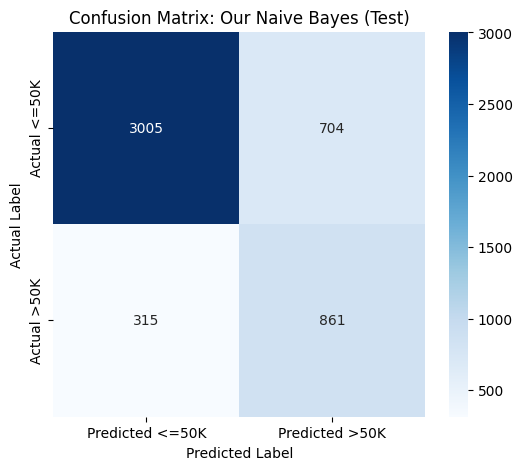


Classification report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      3709
           1       0.55      0.73      0.63      1176

    accuracy                           0.79      4885
   macro avg       0.73      0.77      0.74      4885
weighted avg       0.82      0.79      0.80      4885



In [ ]:
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Merge train + val
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

# Train final model with best alpha
best_model = train_naive_bayes_discrete(X_train_full, y_train_full, n_classes, alpha=best_alpha)
y_test_pred = predict(best_model, X_test)

def evaluate_all_metrics(y_true, y_pred, name=""):
    print(f"\n {name} ")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.2%}") # Display as percentage

    # Per-class precision/recall/F1
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )
    print("\nPer-class metrics:")
    for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):
        print(f"Class {i}: precision={p:.2%}, recall={r:.2%}, f1={f:.2%}, support={s}") # Display as percentage

    # Macro-averaged metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )
    print("\nMacro-averaged:")
    print(f"Precision_macro={precision_macro:.2%}") # Display as percentage
    print(f"Recall_macro   ={recall_macro:.2%}")   # Display as percentage
    print(f"F1_macro       ={f1_macro:.2%}")       # Display as percentage

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Predicted <=50K', 'Predicted >50K'],
        yticklabels=['Actual <=50K', 'Actual >50K']
    )
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Optional pretty text report
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))

    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "confusion_matrix": cm,
    }

metrics_test = evaluate_all_metrics(y_test, y_test_pred, name="Our Naive Bayes (Test)")

### 1. Load Data and Preprocess

### 2. Encode Features and Split Data

### 3. Implement Naive Bayes Training Function

### 4. Implement Naive Bayes Prediction Functions

### 5. Hyperparameter Tuning (Alpha) and Model Selection

### 6. Evaluate Custom Naive Bayes Model

### 7. Evaluate Scikit-learn's Multinomial Naive Bayes

### 8. Analyze Prediction Probabilities


 sklearn MultinomialNB (Test) 
Accuracy: 74.21%

Per-class metrics:
Class 0: precision=83.36%, recall=82.50%, f1=82.93%, support=3709
Class 1: precision=46.54%, recall=48.04%, f1=47.28%, support=1176

Macro-averaged:
Precision_macro=64.95%
Recall_macro   =65.27%
F1_macro       =65.10%

Confusion Matrix:


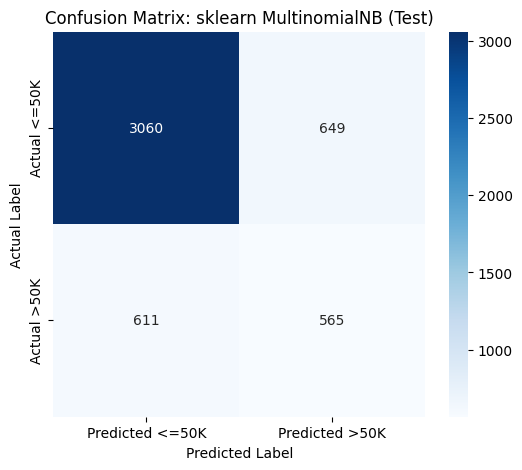


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      3709
           1       0.47      0.48      0.47      1176

    accuracy                           0.74      4885
   macro avg       0.65      0.65      0.65      4885
weighted avg       0.74      0.74      0.74      4885



In [ ]:
from sklearn.naive_bayes import MultinomialNB

sk_model = MultinomialNB(alpha=best_alpha)
sk_model.fit(X_train_full, y_train_full)
y_test_pred_sk = sk_model.predict(X_test)

metrics_test_sk = evaluate_all_metrics(y_test, y_test_pred_sk, name="sklearn MultinomialNB (Test)")


In [ ]:
def log_probs_to_probs(log_probs):
    # log_probs shape: (N, n_classes)
    max_log = np.max(log_probs, axis=1, keepdims=True)
    stabilized = log_probs - max_log
    exp_vals = np.exp(stabilized)
    probs = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)
    return probs

log_probs_test = predict_log_proba(best_model, X_test)
probs_test = log_probs_to_probs(log_probs_test)  # shape (N, n_classes)

# probability of class 1 (e.g., >50K) for each sample
p_class1 = probs_test[:, 1]

print("\nProbability analysis for class 1 (>50K):")
print("Mean probability:", p_class1.mean())
print("Min probability :", p_class1.min())
print("Max probability :", p_class1.max())

# simple bins: how confident is the model?
bins = [0.0, 0.5, 0.7, 0.9, 1.0]
counts = np.histogram(p_class1, bins=bins)[0]
total = len(p_class1)
for (b1, b2), c in zip(zip(bins[:-1], bins[1:]), counts):
    print(f"P(class=1) in [{b1:.1f}, {b2:.1f}): {c} samples ({c/total*100:.2f}%)")



Probability analysis for class 1 (>50K):
Mean probability: 0.3072956933929807
Min probability : 5.084184501714922e-07
Max probability : 0.9973937568064307
P(class=1) in [0.0, 0.5): 3320 samples (67.96%)
P(class=1) in [0.5, 0.7): 499 samples (10.21%)
P(class=1) in [0.7, 0.9): 531 samples (10.87%)
P(class=1) in [0.9, 1.0): 535 samples (10.95%)
